# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [39]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2021-12-30 20:11:07--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 3.5.162.150
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|3.5.162.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  24.8MB/s    in 47s     

2021-12-30 20:11:56 (23.1 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affenp

In [6]:
%%capture
!aws s3 cp dogImages s3://udacitysolution3/ --recursive

In [111]:
%%capture
!pip install smdebug torch torchvision tqdm

In [3]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
import os

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [28]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Testing Loss", "Regex": "Testing Loss: ([0-9\\.]+)"},
                     {"Name": "Testing Accuracy", "Regex": "Testing Accuracy: ([0-9\\.]+)"}]


In [15]:
#TODO: Create estimators for your HPs


estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version='1.4.0',
    instance_count=2,
    instance_type='ml.g4dn.xlarge',
    py_version='py3'
)

print(metric_definitions)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=objective_type
)


[{'Name': 'Test Loss', 'Regex': 'Testing Loss: ([0-9\\.]+)'}, {'Name': 'Test Accuracy', 'Regex': 'Testing acc: ([0-9\\.]+)'}, {'Name': 'Test Best Loss', 'Regex': 'Testing best loss: ([0-9\\.]+)'}]


In [115]:
# TODO: Fit your HP Tuner
os.environ['SM_CHANNEL_TRAINING']='s3://udacitysolution3/'
os.environ['SM_MODEL_DIR']='s3://udacitysolution3/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://udacitysolution3/output/'
tuner.fit({"training": 's3://udacitysolution3/'})

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [116]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-211231-1907')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch_size  learning_rate                            TrainingJobName  \
1      "256"       0.007872  pytorch-training-211231-1907-004-92dc71a4   
4      "256"       0.001394  pytorch-training-211231-1907-001-cc48cecc   
3      "128"       0.012419  pytorch-training-211231-1907-002-c9d697a2   
0      "128"       0.005979  pytorch-training-211231-1907-005-ba718a1f   
2      "128"       0.007313  pytorch-training-211231-1907-003-842905fc   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
1         Completed                544.0 2021-12-31 19:10:30+00:00   
4         Completed                540.0 2021-12-31 19:10:13+00:00   
3         Completed                479.0 2021-12-31 19:10:34+00:00   
0         Completed                234.0 2021-12-31 19:35:13+00:00   
2         Completed                214.0 2021-12-31 19:10:19+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
1 2021-12-31 19:31:10+00:00                      1240.0  
4 2021-12-31 19:31:03+00:00                      1250.0  
3 2021-12-31 19:31:09+00:00                      1235.0  
0 2021-12-31 19:56:05+00:00                      1252.0  
2 2021-12-31 19:31:01+00:00                      1242.0

In [46]:
#BetterTrainingJobName='pytorch-training-211231-1447-001-f1374e67'

In [47]:
#my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)



2021-12-31 15:11:16 Starting - Preparing the instances for training
2021-12-31 15:11:16 Downloading - Downloading input data
2021-12-31 15:11:16 Training - Training image download completed. Training in progress.
2021-12-31 15:11:16 Uploading - Uploading generated training model
2021-12-31 15:11:16 Completed - Training job completed


In [48]:
#my_estimator.hyperparameters()

{'_tuning_objective_metric': 'average test loss',
 'batch_size': '"128"',
 'learning_rate': '0.011810516722147538',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2021-12-31-14-47-31-042"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-764520213971/pytorch_dog_hpo-2021-12-31-14-47-31-042/source/sourcedir.tar.gz"'}

In [117]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-31 19:31:01 Starting - Preparing the instances for training
2021-12-31 19:31:01 Downloading - Downloading input data
2021-12-31 19:31:01 Training - Training image download completed. Training in progress.
2021-12-31 19:31:01 Uploading - Uploading generated training model
2021-12-31 19:31:01 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"128"',
 'learning_rate': '0.0073128711354690625',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2021-12-31-19-07-33-178"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-764520213971/pytorch_dog_hpo-2021-12-31-19-07-33-178/source/sourcedir.tar.gz"'}

In [118]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 128, 'learning_rate': '0.0073128711354690625'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [5]:
# TODO: Set up debugging and profiling rules and hooks


# rules = [
#     Rule.sagemaker(rule_configs.loss_not_decreasing()),
#     ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
#     ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
#     Rule.sagemaker(rule_configs.vanishing_gradient()),
#     Rule.sagemaker(rule_configs.overfit()),
#     Rule.sagemaker(rule_configs.overtraining()),
#     Rule.sagemaker(rule_configs.poor_weight_initialization()),
# ]

In [ ]:
#  hook_config = DebuggerHookConfig(
#     hook_parameters={
#         "train.save_interval": "100",
#         "eval.save_interval": "10"
#     }
# )

# profiler_config = ProfilerConfig(
#     system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
# ) 


In [30]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

In [31]:
# TODO: Create and fit an estimator
hyperparameters = {'batch_size': 128, 'learning_rate': '0.0073128711354690625'}

# estimator = PyTorch(
#     entry_point='train_model.py',
#     base_job_name='new-dog-pytorch',
#     role=role,
#     instance_count=2,
#     instance_type='ml.g4dn.xlarge',
#     framework_version='1.4.0',
#     py_version='py3',
#     hyperparameters=hyperparameters,
#     ## Debugger and Profiler parameters
#     rules = rules,
#     debugger_hook_config=hook_config,
#     profiler_config=profiler_config,
# )

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=2,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

In [32]:
estimator.fit({"training": "s3://udacitysolution3/"}, wait=True)

2022-01-01 12:58:35 Starting - Starting the training job...
2022-01-01 12:58:59 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-01 12:59:59 Starting - Preparing the instances for training.........
2022-01-01 13:01:20 Downloading - Downloading input data......
2022-01-01 13:02:36 Training - Downloading the training image...
2022-01-01 13:03:00 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-01 13:02:53,875 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-01-01 13:02:53,896 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this

In [33]:
# TODO: Plot a debugging output.
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
import sagemaker
from sagemaker.pytorch import PyTorch
import boto3
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import os
import IPython

In [34]:
session = boto3.session.Session()
region = session.region_name

In [35]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2022-01-01-12-58-34-572
Region: us-east-1


In [36]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))


[2022-01-01 13:07:16.962 ip-172-16-99-115:18761 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-764520213971/pytorch-training-2022-01-01-12-58-34-572/debug-output
[2022-01-01 13:07:17.730 ip-172-16-99-115:18761 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-01 13:07:18.748 ip-172-16-99-115:18761 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input

In [43]:
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-764520213971/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-us-east-1-764520213971/pytorch-training-2022-01-01-12-58-34-572/profiler-output


Profiler data from system is available


In [44]:
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

In [45]:
view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-01-01 13:20:10.482 ip-172-16-99-115:18761 INFO metrics_reader_base.py:134] Getting 12 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-2', 'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-2', 'GPUUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-2'}


In [46]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-764520213971/pytorch-training-2022-01-01-12-58-34-572/rule-output


In [47]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2022-01-01 13:06:18     342061 pytorch-training-2022-01-01-12-58-34-572/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-01 13:06:17     185499 pytorch-training-2022-01-01-12-58-34-572/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-01 13:06:13        191 pytorch-training-2022-01-01-12-58-34-572/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-01 13:06:13      23439 pytorch-training-2022-01-01-12-58-34-572/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-01 13:06:13        126 pytorch-training-2022-01-01-12-58-34-572/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-01 13:06:13        129 pytorch-training-2022-01-01-12-58-34-572/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-01 13:06:13      10607 pytorch-training-2022-01-01-12-58-34-572/rule-output/ProfilerReport/profiler-output/profiler-re

In [48]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [49]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

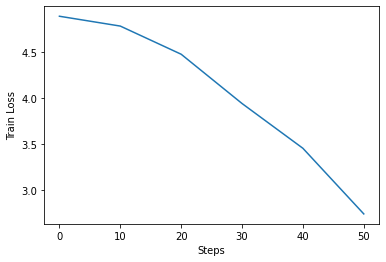

In [42]:
# Plot a debugging output.
import matplotlib.pyplot as plt


plt.ylabel('Train Loss')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=ModeKeys.TRAIN),
         list(trial.tensor('CrossEntropyLoss_output_0').values(mode=ModeKeys.TRAIN).values()))
plt.show()

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

- There is no anomalous behaviour as we are getting a proper curve. TO make it better or to debug if an issue is there we can put various condition in debugger to stop the training and then after resolving the bug start back again.

        Example: Default training configuration ran the training for too long. Instead of training for 4,000 steps, early_stopping should have been applied after 1,000 stepsWe can use Debugger to enable auto-termination, which stops the training when a rule triggers. For our use case, doing so reduces compute time by more than half (orange curve).

## Model Deploying

In [168]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [169]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [170]:
model_location='s3://sagemaker-us-east-1-764520213971/new-dog-pytorch-2021-12-31-20-43-33-289/output/model.tar.gz'


In [186]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [187]:
# TODO: Deploy your model to an endpoint

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large') # TODO: Add your deployment configuration like instance type and number of instances

------!

In [173]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

In [174]:
# TODO: Run an prediction on the endpoint


image = requests.get(request_dict['url']).content # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image, initial_args={"ContentType": "image/jpeg"})

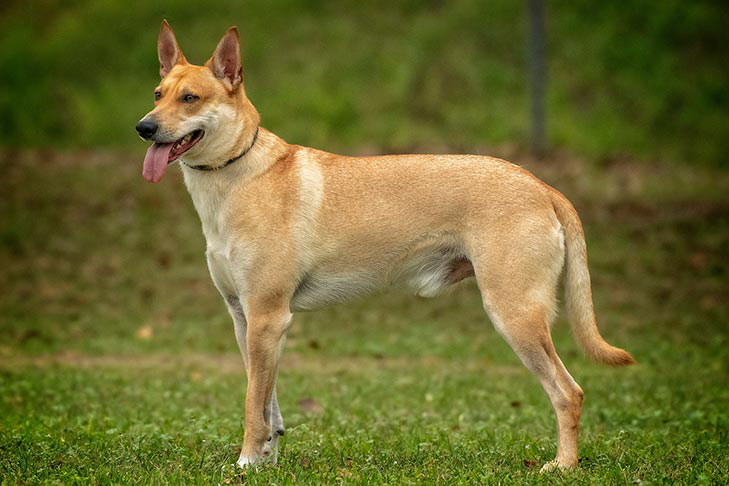

In [175]:
from PIL import Image
import io
Image.open(io.BytesIO(image))

In [176]:
response

[[-0.6415523290634155,
  -0.12460799515247345,
  0.7177702784538269,
  -0.6309214234352112,
  -1.1452345848083496,
  -0.7659636735916138,
  0.6155670285224915,
  0.4620336592197418,
  -0.05090753734111786,
  0.3429403305053711,
  -0.5918443202972412,
  -0.6138219237327576,
  0.0010831579566001892,
  0.5637652277946472,
  0.08814770728349686,
  -0.04663285240530968,
  -0.9259607791900635,
  0.2519819438457489,
  -0.4057358503341675,
  0.35708627104759216,
  -0.6158134341239929,
  -0.7999992370605469,
  -0.6890853643417358,
  -1.4274191856384277,
  -0.15514668822288513,
  -0.48578083515167236,
  0.6667336821556091,
  -0.6463117599487305,
  -0.3692387342453003,
  0.5194752216339111,
  0.2626229226589203,
  -0.2545449137687683,
  -1.2164939641952515,
  0.6320521235466003,
  0.4925529360771179,
  0.2081209123134613,
  0.7623312473297119,
  0.14057113230228424,
  0.4936959147453308,
  0.04825396463274956,
  0.7600356340408325,
  -0.5199853777885437,
  -0.00025410763919353485,
  0.58544504642

In [183]:
import torch
import numpy as np
np.argmax(response, 1)

array([56])

In [185]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()